### Data Complexity Calculation

### Data Complexity Calculation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

In [21]:
F0 = np.arange(1, 10.5, 0.5)
N = 10
Jz = 0.8* np.linspace(0.98, 1, N)

F0

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

# The following blocks of code are responsible for generating data for Hamiltonian given in Eq (1) for various amplitudes between 1 and 10. Note that amplitude = 1 corresponds to **Case 1** in the paper while amplitude = 10 corresponds to **Case 2**. 

In [ ]:

h_alt = np.ones(N) #implies same field at all sites



# Setup operators for individual qubits
sx_list, sy_list, sz_list = [], [], [] #we need to fill them with required tensor product operators as per the dimentions
for i in range(N):
    op_list = [qeye(2)] * N # creates a list of N identities
    op_list[i] = 1/2 * sigmax() # replaces the ith list with sigma and in the next step does the tensor product
    sx_list.append(tensor(op_list)) 
    op_list[i] = 1/2 * sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = 1/2 * sigmaz()
    sz_list.append(tensor(op_list))

# Hamiltonian - Energy splitting terms
V_target=0
H_alt = 0
for i in range(N):
    V_target -=  h_alt[i] * sx_list[i] #the extra term with magnetic field is kept under V_target

# Interaction terms
for n in range(N - 1):

    H_alt +=  -Jz[n] * sz_list[n] * sz_list[n + 1]

# the periodic boundary condition
H_alt +=  -Jz[-1] * sz_list[-1] * sz_list[0]

H0_target = H_alt
H0_target.eigenenergies()

E, V = H0_target.eigenstates()

ψ0  = V[0]

full_ω = np.linspace(0.55, (E[-1] - E[0])+0.3, 200)
t = np.linspace(0, 2 * np.pi / full_ω[0], 512)

In [5]:
Y=[]

for i in F0:
    Y1 = [sesolve([H0_target, [V_target, i * np.sin(ω * t)]], ψ0, t, e_ops=[V_target,]).expect[0].reshape(-1, 1)
        for ω in full_ω ]  
    Y.append(Y1)


Y = np.array(Y)

Note that Y contains output data for all amplitiudes.

In [ ]:
np.save('Y_data_amp_full.npy', Y)

In [7]:
Y = np.load('Y_data_amp_full.npy',  allow_pickle=True)
Y.shape

(19, 200, 512, 1)

# The following code calculates mean Pnorm values for each amplitude as in $F_{0}$ for integrable Hamiltonians.

In [24]:
import EntropyHub as EH
complexity = []
for i in range(Y.shape[0]):
    s = []
    for j in range(Y.shape[1]):
        
        Z = Y[i,j,:]

        Perm, Pnorm, cPE = EH.PermEn(Z, m = 4, tau = 1, Typex = 'ampaware',
                                    tpx = 1, Logx = 10, Norm = False)
        s.append(Pnorm[3])
        
    complexity.append(np.mean(np.array(s)))
    print('Mean Complexity for Amplitude = {}: '.format(F0[i]), complexity[i])
        

Mean Complexity for Amplitude = 1.0:  0.12690055161420347
Mean Complexity for Amplitude = 1.5:  0.13140576343016275
Mean Complexity for Amplitude = 2.0:  0.13448668142369208
Mean Complexity for Amplitude = 2.5:  0.1381827593788814
Mean Complexity for Amplitude = 3.0:  0.14386957493121397
Mean Complexity for Amplitude = 3.5:  0.15026426878803098
Mean Complexity for Amplitude = 4.0:  0.15556565102995448
Mean Complexity for Amplitude = 4.5:  0.1597569103930722
Mean Complexity for Amplitude = 5.0:  0.1643678551161095
Mean Complexity for Amplitude = 5.5:  0.16942163314027409
Mean Complexity for Amplitude = 6.0:  0.17622071734062866
Mean Complexity for Amplitude = 6.5:  0.18206684043114912
Mean Complexity for Amplitude = 7.0:  0.18583411519708126
Mean Complexity for Amplitude = 7.5:  0.18886470963742752
Mean Complexity for Amplitude = 8.0:  0.19252091087165227
Mean Complexity for Amplitude = 8.5:  0.19636090240455303
Mean Complexity for Amplitude = 9.0:  0.19993122873654742
Mean Complexity f

Similarly, for **Case 3**, with an amplitude $F_0 = 1.5$, the mean pnorm value, representing the complexity measure, was found to be **0.13844745508507483** and for **Case 4**, with an amplitude $F_0 = 2.5$, the mean pnorm value was calculated as **0.14441512522938718**.

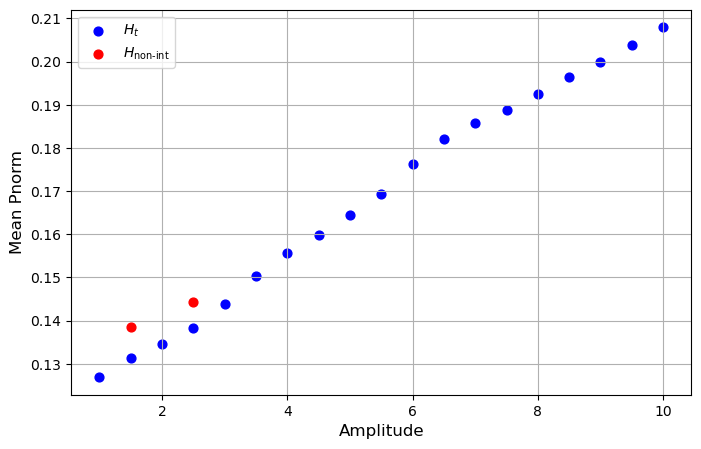

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot
amplitude = F0.tolist()
mean_pnorm = complexity

# The mean complexity amplitude for the case 3 & 4 are similarly calculated and are given below.
h_non_int_points = [0.13844745508507483, 0.14441512522938718]  # Selected y-values
h_non_int_amplitude = [1.5, 2.5]  # Corresponding x-coordinates

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(amplitude, mean_pnorm, color='blue', label=r'$H_t$', s=40)
plt.scatter(h_non_int_amplitude, h_non_int_points, color='red', label=r'$H_{\mathrm{non\text{-}int}}$', s=40)

# Labels and legend
plt.xlabel('Amplitude', fontsize=12)
plt.ylabel('Mean Pnorm', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
